## Импорт библиотек
Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import json
import geopandas as gpd

from shapely.geometry import Polygon, Point, MultiPolygon

import numpy as np
import matplotlib.pyplot as plt

Путь к данным:

In [2]:
DATA_PATH = './datasets/'
SERV_RADIUS = 1000 #метров до поликлинники по СП 42.13330.2016

## Загрузим датасеты.

### Location
**01_Location_July.csv** и **01_CLocation_July.csv** - Сгенерированный датасет о численности населения на территории Москвы и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные об изменении численности населения на территории

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***
- Количество человек, проживающих на территории района/сектора
- Количество человек, работающих на территории района/сектора
- Количество человек, которые находились на территории района/сектора по будням в дневное время чаще, чем в любых других районах/секторах, в рассматриваемый месяц
- Количество человек, проживающих на территории района/сектора и имеющих разъездную работу

In [4]:
df_loc = pd.read_csv(DATA_PATH + '01_Location_July.csv')
print(df_loc.shape)
df_loc.head(3)

(146, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,1,31723,11029,23944,1411
1,2,64780,15890,40845,3536
2,3,69098,39701,63486,4161


In [3]:
df_cloc = pd.read_csv(DATA_PATH + '01_CLocation_July.csv')
print(df_cloc.shape)
df_cloc.head(3)

(10240, 5)


,zid,customers_cnt_home,customers_cnt_job,customers_cnt_day,customers_cnt_move
0,32909,4,0,0,0
1,32910,25,8,26,0
2,33261,2,0,2,0


### Matrix_Home_Work

**04_Matrix_Home_Work_July**; **04_CMatrix_Home_Work_July.csv** - Сгенерированный датасет о динамике перемещения населения дом-работа на территории Москвы (Матрица корреспонденции дом-работа) и с гранулярностью по районам города Москвы и секторами 500х500 метров.

***Характер данных***: Данные Матрица корреспонденции дом-работа

***Временное разбиение***: календарный месяц

***Территориальное разбиение***: Москва, разбитая по административным районам и на сектора 500х500м.

***Перечень показателей данных в данных:***

- Количество человек, место проживания которых в отчетном месяце находится в районе/секторе А, а место работы - в районе/секторе В

In [5]:
df_home_work = pd.read_csv(DATA_PATH + '04_Matrix_Home_Work_July.csv')
df_chome_work = pd.read_csv(DATA_PATH + '04_CMatrix_Home_Work_July.csv')

## Административное деление районов

Загрузим так же справочник соотношения секторов 500х500м и административного деления районов Москвы

In [6]:
df_sector_rel = pd.read_csv(DATA_PATH + 'relations_between_500x500_and_MSC.csv')
df_sector_rel.head(3)

,cell_zid,area_peresechenia_s_admzone_kv.km,adm_zid,adm_name,okrug_name,sub_ter
0,32909,0.407116,216,Роговское,Троицкий административный округ,Новая Москва
1,32910,1.003458,216,Роговское,Троицкий административный округ,Новая Москва
2,33261,0.233312,216,Роговское,Троицкий административный округ,Новая Москва


In [7]:
df_sector_rel['sub_ter'].value_counts()

Новая Москва     6734
Старая Москва    6498
Name: sub_ter, dtype: int64

In [8]:
new_zid_list = df_sector_rel.query('sub_ter == "Новая Москва"')['cell_zid'].to_list()

## Загрузим геоданные

In [9]:
shp_admzones = gpd.read_file(DATA_PATH + 'admzones2021/admzones2021.shp').to_crs(epsg=32637)
shp_fishnet = gpd.read_file(DATA_PATH + 'fishnet2021/fishnet2021.shp').to_crs(epsg=32637)

In [10]:
shp_admzones.head(2)

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry
0,519,Коломна,None,Московская область,NaN,1.728866e+09,"POLYGON ((455694.923 6079507.744, 455694.900 6..."
1,507,Дзержинский,None,Московская область,NaN,1.566430e+07,"POLYGON ((424049.408 6164789.852, 424184.970 6..."


Оставим только данные, относящиеся к Москве:

In [11]:
shp_moscow = shp_admzones[(shp_admzones['sub_ter'] == 'Старая Москва') |\
                          (shp_admzones['sub_ter'] == 'Новая Москва')]

shp_mosnet = shp_fishnet.sjoin(shp_moscow, how="inner", predicate='intersects')

In [12]:
#ax = shp_admzones.plot(figsize=(17,17), alpha=0.5)
df_cloc
pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="inner",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).head(2)
#).plot(figsize=(17,17), color='red', alpha=0.01)

#plt.show()

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry,cell_zid
0,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107514
1,109,Перово,Восточный административный округ,Старая Москва,561.0,9.829908e+06,"POLYGON ((421956.761 6180023.056, 422428.189 6...",107515


In [13]:
import json
def coords(row):
    data = row['geodata_center']
    coord = json.loads(data)['coordinates']
    type_ = json.loads(data)['type']
    return coord, type_

In [14]:
#df_culture['geodata_center'][0]
#json.loads(df_culture['geodata_center'][0])['type']

In [15]:
#df_culture[['coordinates', 'type']] = df_culture.apply(coords, axis=1, result_type='expand')

## Загрузим наборы данных с data.mos.ru

Загрузим наборы данных с `data.mos.ru`, а именно:

1. [Поликлиническая помощь взрослым](https://data.mos.ru/opendata/503/)
1. [Поликлиническая помощь детям](https://data.mos.ru/opendata/505/)
1. [Границы зон охраны объектов культурного наследия](https://data.mos.ru/opendata/613/)
1. [Парковые территории](https://data.mos.ru/opendata/1465)

In [16]:
df_adult = pd.read_json(DATA_PATH + 'mos_ru/503_clinic_adult.json', encoding='windows-1251')
df_child = pd.read_json(DATA_PATH + 'mos_ru/505_clinic_child.json', encoding='windows-1251')

df_zculture = pd.read_json(DATA_PATH + 'mos_ru/613_zones_culture.json', encoding='windows-1251')
df_zpark = pd.read_json(DATA_PATH + 'mos_ru/1465_zones_park.json', encoding='windows-1251')

Функция для выделения координаты из данных:

In [17]:
def coords(row):
    data = row['geoData']
    if data['type'] == 'MultiPoint':
        return Point(data['coordinates'][0][0], data['coordinates'][0][1])
    elif data['type'] == 'MultiPolygon':
        try:
            return MultiPolygon(data['coordinates'][0])
        except:
            return Polygon(data['coordinates'][0][0])
    else:
        return Polygon(data['coordinates'][0])

In [18]:
def test(row):
    return row['geoData']['type']
    
df_zpark['test'] = df_zpark.apply(test, axis=1)

In [19]:
#df_adult[['longitude', 'latitude']] = df_adult.apply(coords, axis=1, result_type='expand')
df_adult['geometry'] = df_adult.apply(coords, axis=1)
df_child['geometry'] = df_child.apply(coords, axis=1)
df_zculture['geometry'] = df_zculture.apply(coords, axis=1)
df_zpark['geometry'] = df_zpark.apply(coords, axis=1)

Создадим объекты типа **GeoDataFrame**

In [20]:
gdf_adult = gpd.GeoDataFrame(
    df_adult[['ShortName', 'geometry']],
    geometry=df_adult.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_child = gpd.GeoDataFrame(
    df_child[['ShortName', 'geometry']],
    geometry=df_adult.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_zculture = gpd.GeoDataFrame(
    df_zculture[['ObjectNameOnDoc', 'geometry']],
    geometry=df_zculture.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

gdf_zpark = gpd.GeoDataFrame(
    df_zpark[['CommonName', 'geometry']],
    geometry=df_zpark.geometry,
    crs="EPSG:4326").to_crs(epsg=32637)

Добавим буфера - зоны диаметром в зону обслуживания поликлинники в соответствии с *СП 42.13330.2016 "Градостроительство. Планировка и застройка городских и сельских поселений"*

In [21]:
gdf_adult_buff = gdf_adult.geometry.buffer(SERV_RADIUS)
gdf_child_buff = gdf_child.geometry.buffer(SERV_RADIUS)

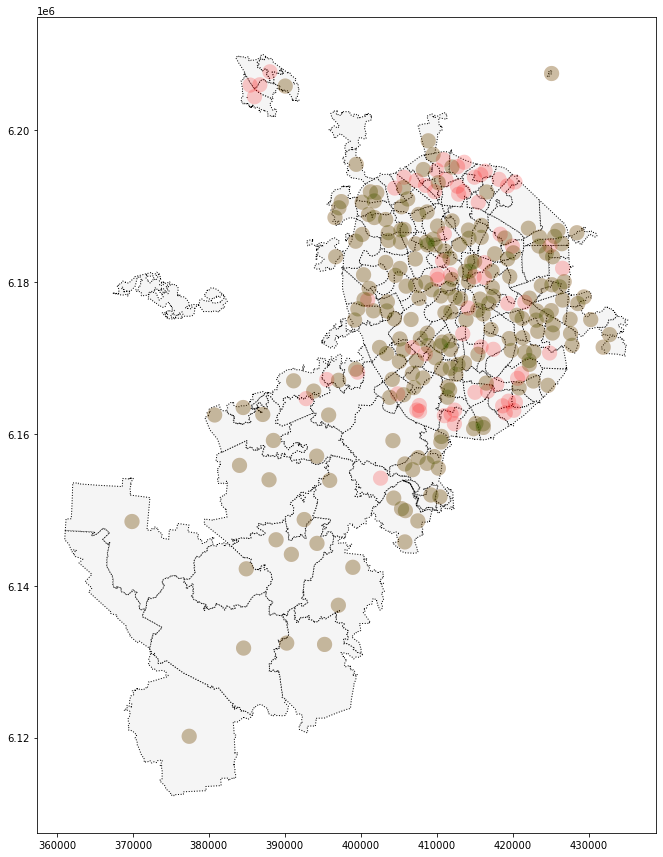

In [22]:
ax = shp_moscow.plot(
    figsize=(15,15), color='whitesmoke', linestyle=':', edgecolor='black'
)
#gdf_adult.plot(color='red', ax=ax, markersize=2)
#gdf_child.plot(color='green', ax=ax, markersize=2)
gdf_adult_buff.plot(color='red', ax=ax, alpha=0.2)
gdf_child_buff.plot(color='green', ax=ax, alpha=0.2)

plt.show()

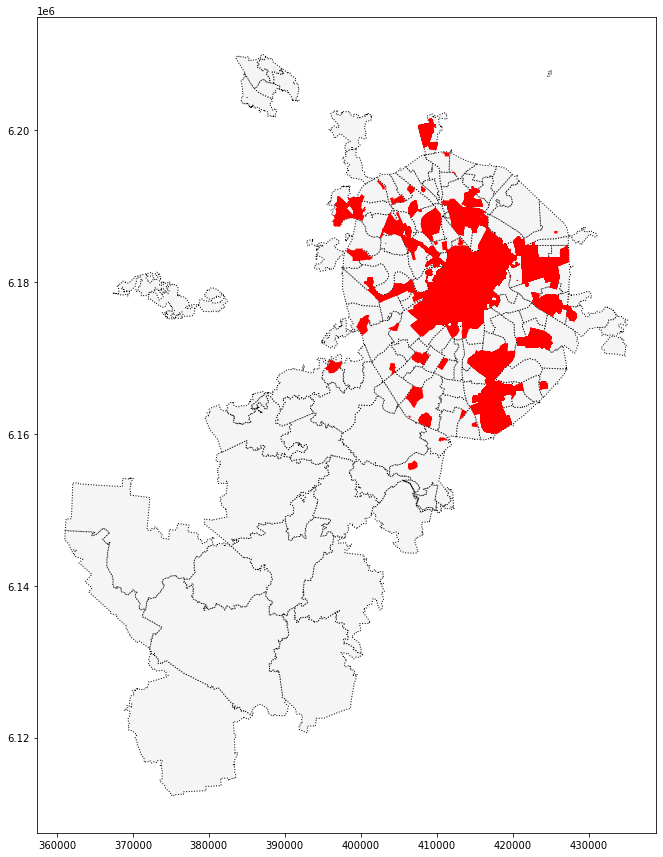

In [23]:
ax = shp_moscow.plot(
    figsize=(15,15), color='whitesmoke', linestyle=':', edgecolor='black'
)
#gdf_adult.plot(color='red', ax=ax, markersize=2)
#gdf_child.plot(color='green', ax=ax, markersize=2)

gdf_zculture.sjoin(gdf_zpark, how="inner", predicate='intersects').plot(color='red', ax=ax, alpha=1)

plt.show()

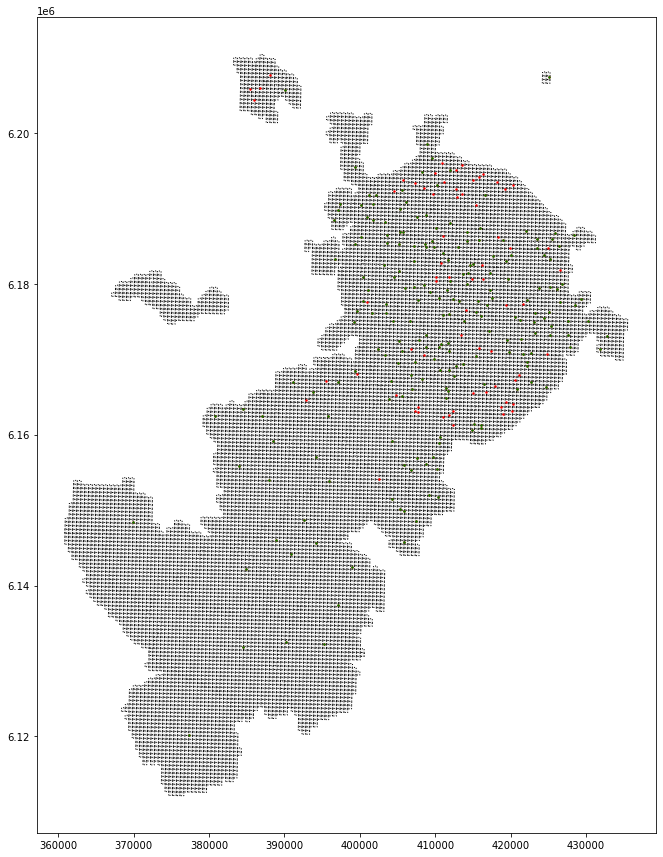

In [24]:
ax = shp_mosnet.plot(
    figsize=(15,15), color='whitesmoke', linestyle=':', edgecolor='black'
)

gdf_adult.plot(color='red', ax=ax, markersize=2)
gdf_child.plot(color='green', ax=ax, markersize=2)

plt.show()

<AxesSubplot:>

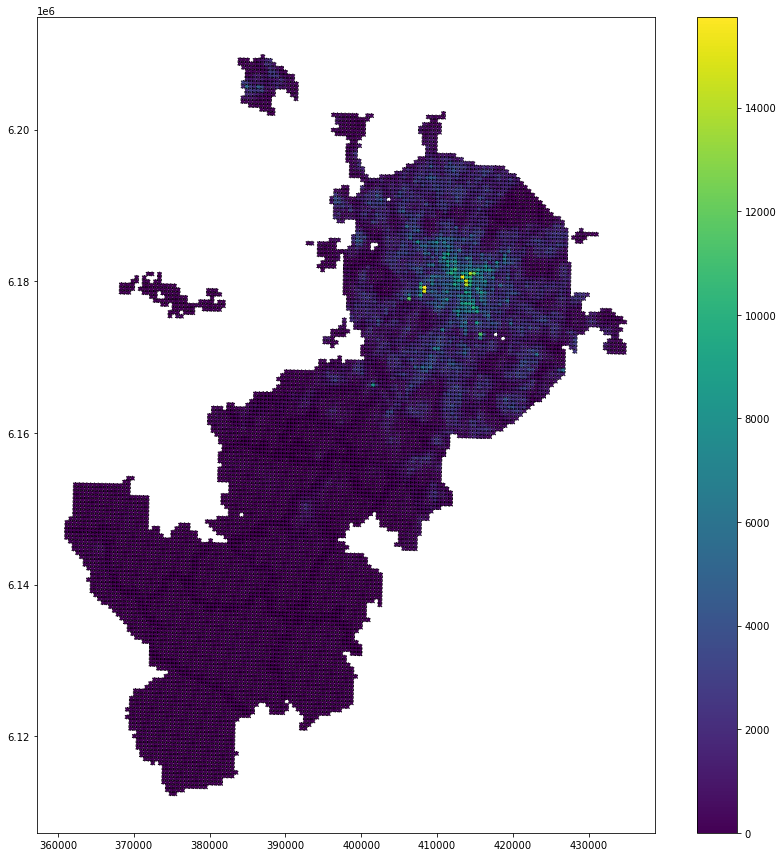

In [35]:
pd.merge(
    shp_mosnet,
    df_cloc,
    how="inner",
    left_on='cell_zid',
    right_on='zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='customers_cnt_day',
                        legend=True)

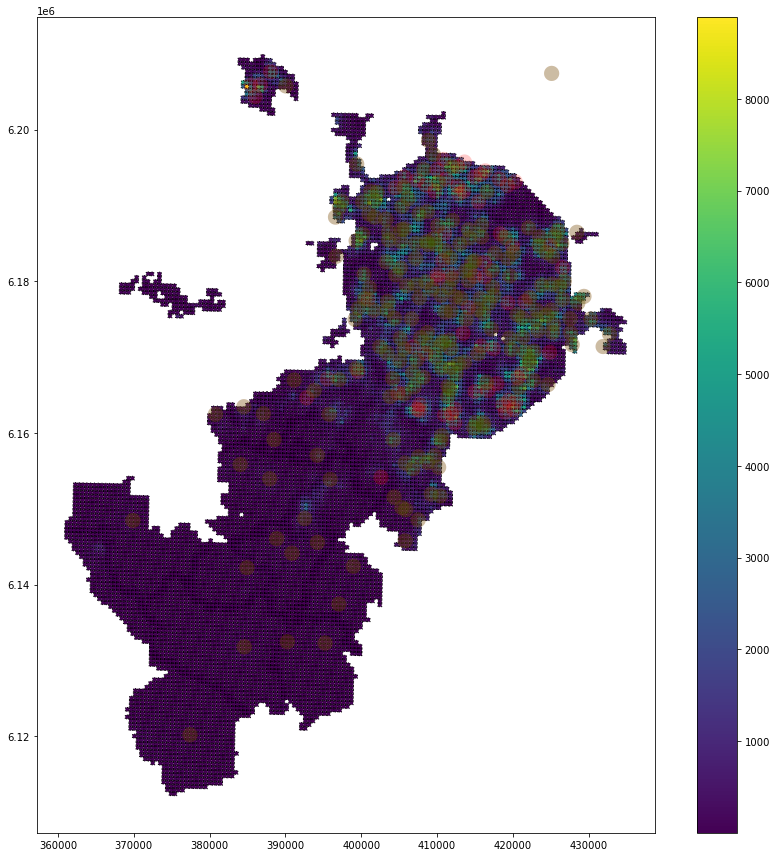

In [37]:
ax = pd.merge(
    shp_mosnet,
    df_cloc,
    how="inner",
    left_on='cell_zid',
    right_on='zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='customers_cnt_home',
                        legend=True)


gdf_adult_buff.plot(color='red', ax=ax, alpha=0.2)
gdf_child_buff.plot(color='green', ax=ax, alpha=0.2)

plt.show()

<AxesSubplot:>

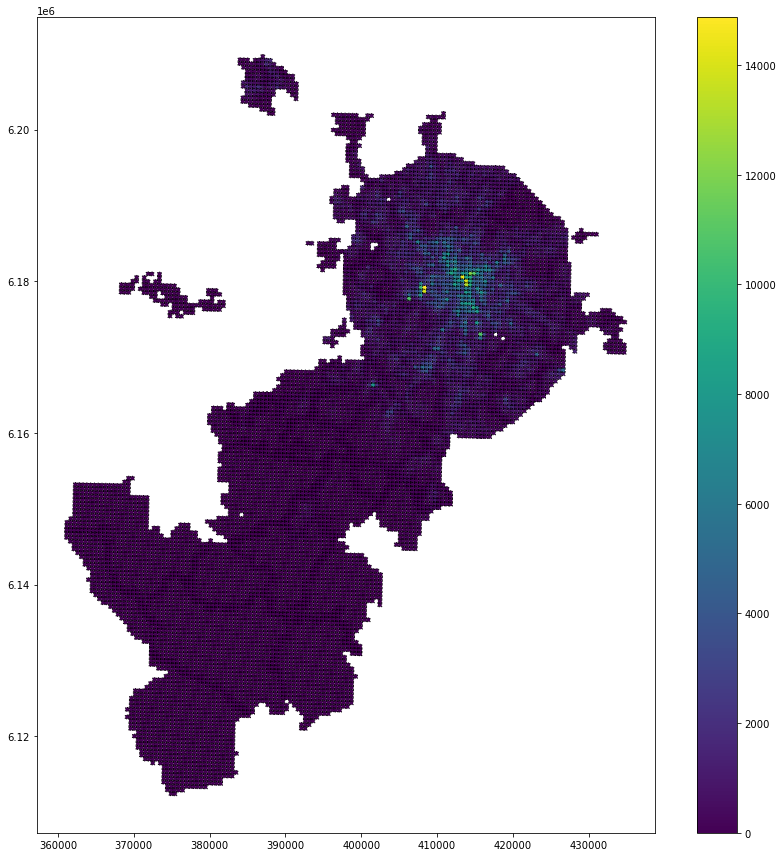

In [33]:
pd.merge(
    shp_mosnet,
    df_cloc,
    how="inner",
    left_on='cell_zid',
    right_on='zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None).plot(figsize=(15,15),
                        linestyle=':',
                        edgecolor='black',
                        column='customers_cnt_job',
                        legend=True)

In [25]:
pd.merge(
    shp_admzones,
    df_sector_rel[['cell_zid', 'adm_zid']],
    how="right",
    on='adm_zid',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
).head(1)

,adm_zid,adm_name,okrug_name,sub_ter,okrug_id,area,geometry,cell_zid
0,216,Роговское,Троицкий административный округ,Новая Москва,572.0,1.782183e+08,"POLYGON ((372220.225 6131755.576, 372284.129 6...",32909
